In [2]:
from streetview import POI

/home/dev/.local/lib/python3.11/site-packages/pyproj/transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/tmp/ipykernel_886052/1954953405.py:55: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_roads = ox.features_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags=tags)
/tmp/ipykernel_886052/1954953405.py:55: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  osm_roads = ox.features_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags=tags)
/home/dev/.local/lib/python3.11/site-packages/pypro

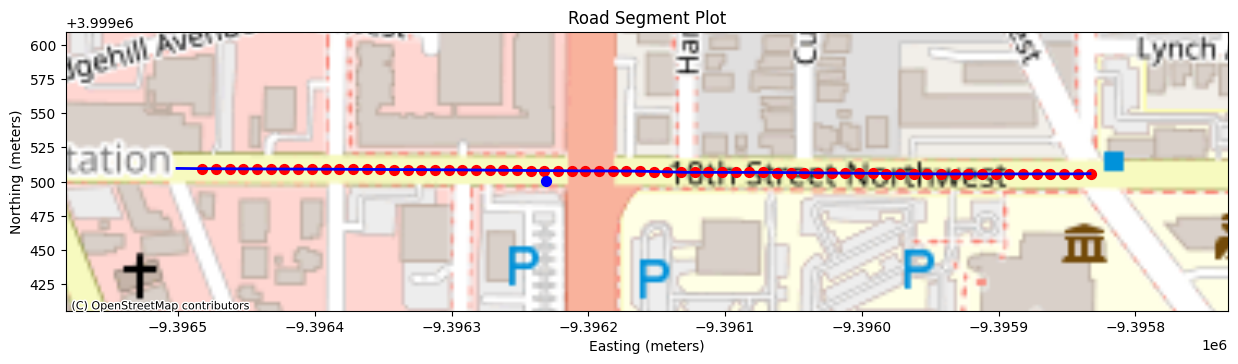

In [23]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
from shapely.geometry import Point
from shapely.ops import linemerge, unary_union
from streetview import POI
import matplotlib.pyplot as plt
import contextily as ctx

# Function to generate points at intervals along a line
def generate_points(road, interval):
    # Project line for meter-based calculations 
    road = road.to_crs("EPSG:3857")

    # Merge into one road 
    if len(road) > 1: 
        road = linemerge(unary_union(road.geometry))

    # Calculate how many points need to be generated
    num_points = int(road.length // interval) + 1 

    # Interpolate num_points many points along the line 
    interpolated_points = [road.interpolate(i*interval) for i in range(num_points)]

    # Create a GeoDataFrame to store the interpolated points, convert to coords
    gdf = gpd.GeoDataFrame(geometry=interpolated_points, crs="EPSG:3857").to_crs("EPSG:4326")
    return gdf

# Function to calculate headings (azimuths) between consecutive coordinates
def calculate_headings(coords):
    headings = []
    for i in range(len(coords) - 1):
        delta_x = coords[i + 1].x - coords[i].x
        delta_y = coords[i + 1].y - coords[i].y
        azi = np.degrees(np.arctan2(delta_x, delta_y))
        headings.append((azi + 360) % 360)  # Normalize heading within 0-360 degrees
    return headings

# Calculate headings to point_sf from each selected point
def calculate_heading_between_points(x1, y1, x2, y2):
    azi = np.degrees(np.arctan2(x1 - x2, y1 - y2))
    return (azi + 360) % 360  # Normalize heading to 0-360 degrees

def get_points(poi: POI, interval=10):
    # Make point into a geodataframe 
    original_pt = gpd.GeoDataFrame(geometry=[Point(poi.coords.lon, poi.coords.lat)], crs="EPSG:4326")
    
    # Make a bounding box around the point 
    point_buffer = original_pt.to_crs(epsg=26916).buffer(200).to_crs("EPSG:4326")
    bbox = point_buffer.total_bounds

    # Retrieve road data within the bounding box from OSM
    tags = {"highway": ["motorway", "trunk", "primary", "secondary", "tertiary", "residential"]}
    osm_roads = ox.features_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags=tags)
    road_lines = osm_roads[osm_roads.geom_type == 'LineString'].to_crs("EPSG:4326")

    # Find the nearest road to the point of interest
    nearest_rd = road_lines.iloc[road_lines.sindex.nearest(original_pt.iloc[0])[1]].iloc[0]
    nearest_rd_name = nearest_rd.get("name")

    # Covnert to geoseries 
    nearest_rd = gpd.GeoSeries([nearest_rd.geometry], crs="EPSG:4326")

    # Get all of the segments of this road within the bounding box, not just one. 
    nearest_rd_all = road_lines[road_lines["name"] == nearest_rd_name]

    # Define interval and generate points along the nearest road
    points = generate_points(nearest_rd_all, interval)

    # Calculate headings if there are multiple points, remove last point 
    if len(points) > 1:
        headings = calculate_headings(points.geometry)
        points = points.iloc[:-1]
        points['Heading'] = headings

    # Plot
    nearest_rd_all = nearest_rd_all.to_crs("EPSG:3857")
    points = points.to_crs("EPSG:3857")
    original_pt = original_pt.to_crs("EPSG:3857")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_aspect('equal')
    minx, miny, maxx, maxy = points.total_bounds
    ax.set_xlim(minx - 100, maxx + 100)  # Expand bounds slightly if desired
    ax.set_ylim(miny - 100, maxy + 100)
    nearest_rd_all.plot(ax=ax, color="blue", linewidth=2)
    points.plot(ax=ax, color="red", marker="o", markersize=50)
    original_pt.plot(ax=ax, color="blue", marker="o", markersize=50)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=16)

    ax.set_title("Road Segment Plot")
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    plt.show()

test = POI(id="15", lat=33.781501, lon=-84.407777)

points = get_points(test)
